## Teil 2

Folgende Regressionsarten werden verwendet um eine Vorhersage des SalePrice zu erstellen:
* Lineare Regression
* Ridge
* SGDRegressor

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, max_error
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge

# prevent deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [169]:
# gets dataFrame from file
def read_data(path):
    df = pd.read_csv(path, sep=";")
    return df

# scaling numerical values and turning objects into numerical values
def scale_and_convert_columns(df, model):
    categoricalCols = []
    for i in range(len(df.columns)):
        if (df.dtypes[i] == object):
            categoricalCols.append(i)
    numericalCols = []
    for i in range(len(df.columns)):
        if (df.dtypes[i] == 'int64' ):
            numericalCols.append(i)        
            
    preprocessor = make_column_transformer((categoricalCols, OneHotEncoder(handle_unknown='ignore')),
                                            (numericalCols, RobustScaler()))
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])
    return pipe

# calculates R2, MSE, RMSE, MAPE and MAX* for the given regression model
def  train_model(path, model):
    df = read_data(path)
    pipe = scale_and_convert_columns(df.drop('SalePrice', axis=1), model)
    
    x = df.drop('SalePrice', axis=1).values #dimensions
    y = df['SalePrice'].values #prediction
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
    pipe.fit(x_train, y_train)
    
    predicted = pipe.predict(x_test)
    expected = y_test
    mse = mean_squared_error(expected, predicted)
    result = {'Regression Type': type(model).__name__, 'R2': r2_score(expected, predicted), 'MSE': mean_squared_error(expected, predicted), 
            'RMSE' : np.sqrt(mse),'MAPE':  np.mean(np.abs((expected-predicted)/expected) * 100), 
            'MAX*': max_error(expected, predicted)}
    return result, model

def calc_prediction(path, model):
    df = read_data(path)
    pipe = scale_and_convert_columns(df.drop('SalePrice', axis=1), model)
    
    x = df.drop('SalePrice', axis=1).values #dimensions
    y = df['SalePrice'].values #prediction
    
    # neg_root_mean_squared_error somehow doesn't work
    scores = cross_validate(pipe, x, y, cv=5, scoring=['r2', 'neg_mean_squared_error', 
                                                      'neg_median_absolute_error', 'max_error' ])
    return {'Regression Type': type(model).__name__,'R2': scores['test_r2'].mean(), 'MSE': scores['test_neg_mean_squared_error'].mean()*-1, 
            'RMSE' : np.sqrt(scores['test_neg_mean_squared_error'].mean()*-1),'MAPE': scores['test_neg_median_absolute_error'].mean()*-1, 
            'MAX*': scores['test_max_error'].mean()*-1}

,Regression Type,R2,MSE,RMSE,MAPE,MAX*
0,LinearRegression,0.894020,3.173257e+08,17813.637951,9.013587,64501.107612
1,Ridge,0.897330,3.074155e+08,17533.267550,8.789771,61505.530768
2,SGDRegressor,0.901837,2.939201e+08,17144.098171,8.384517,50957.046653


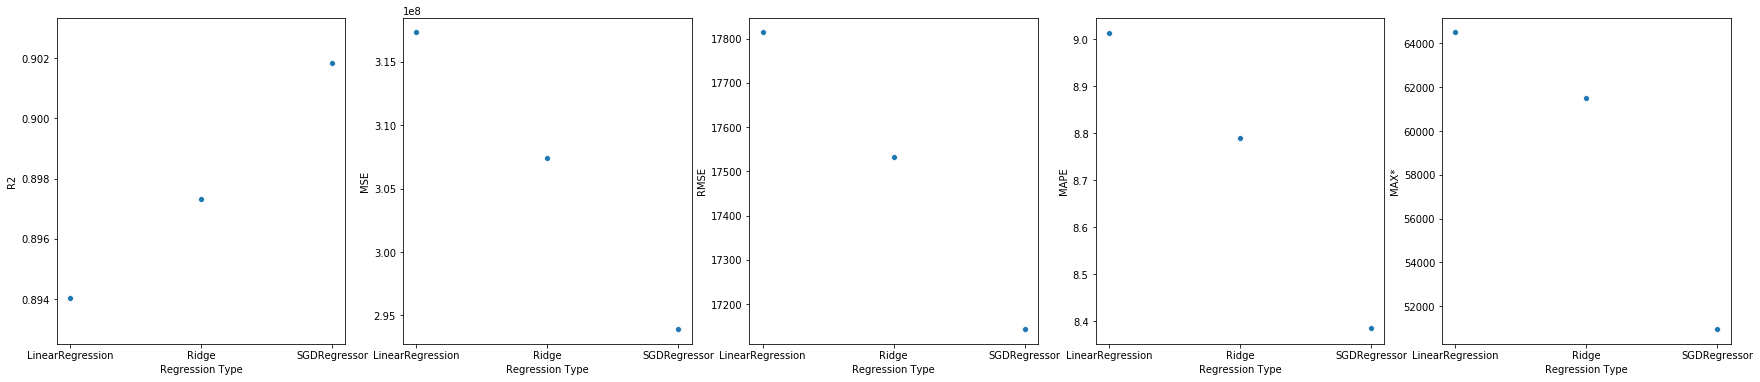

In [170]:
#calculate the score for each model
path = 'cleanedSet.csv'
regressionTypes = [LinearRegression(), Ridge(), SGDRegressor()]
results = []
models = []
for r in regressionTypes:
    result, model = train_model(path, r)
    results.append(result)
    models.append(model)

df = pd.DataFrame(data=results, columns=['Regression Type', 'R2', 'MSE', 'RMSE', 'MAPE', 'MAX*'])

columns = df.columns
fx, axes = plt.subplots(1, len(columns)-1, sharey=False, figsize=(30,6))
for i in range(1, len(columns)):
    # could also use barplot instead of scatterplot
    sns.scatterplot(x=df.columns[0], y=df.columns[i], data=df, ax=axes[i-1])
    
df.head()

## Ergebnis
Generell ist bei den Ergebnissen wünschenswert, das der Bestimmtheitsgrad(R²) so hoch wie möglich ist und alle Fehlerwerte(MSE, RMSE, MAPE und MAX*) so niedrig wie möglich.

Es wurden über 10 verschiedene Regressionsarten von scikit learn getestet und drei der besten (LinearRegression, Ridge und SGDRegressor) für einen genauen vergleich ausgewählt. Durch die Entfernung der Ausreiser konnte der Bestimmtheitsgrad aller 3 Regressionsarten um ca. 3-5% verbessert werden. An der Spitze aktuell der SGDRegressor mit einem Bestimmtheitsgrad von 90%. Bei genauerer Betrachtung fällt auf, das LinearRegression und Ridge sehr nahe beieinander liegen, wobei aber Ridge in allen Werten, besser abschneidet. Beide werden aber vom SGDRegressor geschlagen, vorallem im bereich maximum Error.   

Anhand dieser Ergebnisse würden wir für eine Vorhersage der Verkaufspreise für den SGDRegressor entscheiden.

### Analyseidee
Um die eventuell Ergebnisse und den Prozess noch weiter zu Verbessern könnte versucht werden mehrere der Features zusammen zu fassen. Dies könnte sowohl den Lern- als auch den Vorhersageprozess beschleunigen.

Eine Vorhersage zusätzlicher Daten kann im folgenden Codeteil vorgenommen werden. Hierfür muss nur die folgende path Variable angepasst werden.

In [171]:
path = ''
results = []
if path:
    for m in models:
        results.append(calc_prediction(path, m))

df = pd.DataFrame(data=results, columns=['Regression Type', 'R2', 'MSE', 'RMSE', 'MAPE', 'MAX*'])
df.head()

,Regression Type,R2,MSE,RMSE,MAPE,MAX*
